In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import dirichlet

warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('../data/processed/featured_data.csv')
    print("DataFrame loaded successfully.")
    display(df.head())
except FileNotFoundError:
    print("Error: 'featured_data.csv' not found. Please ensure the file path is correct.")

DataFrame loaded successfully.


,State_Name,Constituency_No,Year,Party,Candidate,Incumbent,N_Cand,Constituency_Type,Votes,Valid_Votes,Vote_Share,Alliance
0,andaman_&_nicobar_islands,1,2019,inc,KULDEEP RAI SHARMA,False,15,GEN,95308.0,207296,45.976768,UPA
1,andaman_&_nicobar_islands,1,2019,bjp,VISHAL JOLLY,False,15,GEN,93901.0,207296,45.298028,NDA
2,andaman_&_nicobar_islands,1,2019,ind,PARITOSH KUMAR HALDAR,False,15,GEN,5341.0,207296,2.576509,Other
3,andaman_&_nicobar_islands,1,2019,aaap,SANJAY MESHACK,False,15,GEN,2839.0,207296,1.369539,Other
4,andaman_&_nicobar_islands,1,2019,bsp,PRAKASH MINJ,False,15,GEN,2486.0,207296,1.199251,Other


In [2]:
# --- Improved Data Preparation ---
sim_df = df[['State_Name', 'Constituency_No', 'Year', 'Party', 'Vote_Share']].copy()
sim_df.dropna(inplace=True)

# Convert to probability (0-1)
sim_df['Vote_Share'] = sim_df['Vote_Share'] / 100.0

# Remove duplicates
sim_df.drop_duplicates(subset=['State_Name', 'Constituency_No', 'Year', 'Party'], inplace=True)

# Create a pivot table to ensure we have all parties for each constituency
constituency_votes = sim_df.pivot_table(
    index=['State_Name', 'Constituency_No', 'Year'],
    columns='Party',
    values='Vote_Share',
    fill_value=0.0
)

# Normalize each constituency to ensure vote shares sum to 1
constituency_votes = constituency_votes.div(constituency_votes.sum(axis=1), axis=0)

print(f"Prepared {len(constituency_votes)} constituencies with {constituency_votes.shape[1]} parties")
display(constituency_votes.head())

Prepared 5892 constituencies with 1465 parties


Party                                           a s p  aa s p  aaap  aabhap  \
State_Name                Constituency_No Year                                
andaman_&_nicobar_islands 1               1980    0.0     0.0   0.0     0.0   
                                          1984    0.0     0.0   0.0     0.0   
                                          1989    0.0     0.0   0.0     0.0   
                                          1991    0.0     0.0   0.0     0.0   
                                          1996    0.0     0.0   0.0     0.0   

Party                                           aacp  aahpty  aam  aamjp  aap  \
State_Name                Constituency_No Year                                  
andaman_&_nicobar_islands 1               1980   0.0     0.0  0.0    0.0  0.0   
                                          1984   0.0     0.0  0.0    0.0  0.0   
                                          1989   0.0     0.0  0.0    0.0  0.0   
                                          1991   0.0     0.0  0.0    0.0  0.0   
                                          1996   0.0     0.0  0.0    0.0  0.0   

Party                                           aapp  ...  yfe  ygp  yjjp  \
State_Name                Constituency_No Year        ...                   
andaman_&_nicobar_islands 1               1980   0.0  ...  0.0  0.0   0.0   
                                          1984   0.0  ...  0.0  0.0   0.0   
                                          1989   0.0  ...  0.0  0.0   0.0   
                                          1991   0.0  ...  0.0  0.0   0.0   
                                          1996   0.0  ...  0.0  0.0   0.0   

Party                                           ykp  ysp  ysrcp  ysrpp  yus  \
State_Name                Constituency_No Year                                
andaman_&_nicobar_islands 1               1980  0.0  0.0    0.0    0.0  0.0   
                                          1984  0.0  0.0    0.0    0.0  0.0   
                                          1989  0.0  0.0    0.0    0.0  0.0   
                                          1991  0.0  0.0    0.0    0.0  0.0   
                                          1996  0.0  0.0    0.0    0.0  0.0   

Party                                           yuva krantikari party  yvp  
State_Name                Constituency_No Year                              
andaman_&_nicobar_islands 1               1980                    0.0  0.0  
                                          1984                    0.0  0.0  
                                          1989                    0.0  0.0  
                                          1991                    0.0  0.0  
                                          1996                    0.0  0.0  

[5 rows x 1465 columns]

In [3]:
# --- Improved Simulation Parameters ---
NUM_SIMULATIONS = 1000
CONCENTRATION_PARAM = 50  # Controls variance: higher = less variance

def simulate_constituency_dirichlet(base_shares, concentration_param=50):
    """
    Simulate vote shares using Dirichlet distribution
    Ensures all vote shares sum to 1 and are between 0-1
    """
    # Add small epsilon to avoid zeros
    base_shares = np.maximum(base_shares, 0.001)
    base_shares = base_shares / np.sum(base_shares)  # Renormalize
    
    # Dirichlet parameters proportional to base shares
    alpha = base_shares * concentration_param
    
    # Simulate from Dirichlet distribution
    simulated = np.random.dirichlet(alpha)
    return simulated

# Store all simulations
all_simulations = []

print("Running improved Monte Carlo simulations...")
for sim_idx in range(NUM_SIMULATIONS):
    simulated_election = []
    
    for constituency_idx, base_shares in enumerate(constituency_votes.values):
        # Get actual base shares (remove zeros for calculation)
        non_zero_mask = base_shares > 0.001
        actual_base = base_shares[non_zero_mask]
        
        if len(actual_base) > 1:
            # Simulate using Dirichlet
            simulated_shares = simulate_constituency_dirichlet(actual_base, CONCENTRATION_PARAM)
        else:
            # Single candidate case
            simulated_shares = np.array([1.0])
        
        # Create full result array
        full_result = np.zeros_like(base_shares)
        full_result[non_zero_mask] = simulated_shares
        
        # Store with constituency info
        constituency_info = constituency_votes.index[constituency_idx]
        for party_idx, party in enumerate(constituency_votes.columns):
            if full_result[party_idx] > 0:
                simulated_election.append({
                    'State_Name': constituency_info[0],
                    'Constituency_No': constituency_info[1],
                    'Year': constituency_info[2],
                    'Party': party,
                    'Vote_Share': full_result[party_idx],
                    'Simulation': sim_idx
                })
    
    # Progress tracking
    if (sim_idx + 1) % 100 == 0:
        print(f"Completed {sim_idx + 1}/{NUM_SIMULATIONS} simulations")
    
    all_simulations.extend(simulated_election)

# Convert to DataFrame
simulated_df = pd.DataFrame(all_simulations)
print(f"Generated {len(simulated_df)} party-constituency-simulation records")

Running improved Monte Carlo simulations...
Completed 100/1000 simulations
Completed 200/1000 simulations
Completed 300/1000 simulations
Completed 400/1000 simulations
Completed 500/1000 simulations
Completed 600/1000 simulations
Completed 700/1000 simulations
Completed 800/1000 simulations
Completed 900/1000 simulations
Completed 1000/1000 simulations
Generated 39057000 party-constituency-simulation records


In [4]:
# --- Memory-efficient approach for winner calculation ---
print("Calculating winners using memory-efficient method...")

# Group by simulation and constituency, then find winner for each
winners_list = []

for sim_num in range(NUM_SIMULATIONS):
    # Get data for current simulation only
    sim_data = simulated_df[simulated_df['Simulation'] == sim_num]
    
    # Group by constituency and find winner
    constituency_winners = sim_data.loc[sim_data.groupby(['State_Name', 'Constituency_No', 'Year'])['Vote_Share'].idxmax()]
    
    # Add simulation number and store
    constituency_winners = constituency_winners[['State_Name', 'Constituency_No', 'Year', 'Party']].copy()
    constituency_winners['Simulation'] = sim_num
    winners_list.append(constituency_winners)
    
    # Progress tracking
    if (sim_num + 1) % 100 == 0:
        print(f"Processed {sim_num + 1}/{NUM_SIMULATIONS} simulations")

# Combine all winners
winners_df = pd.concat(winners_list, ignore_index=True)
print(f"✓ Winners calculated for {len(winners_df)} constituency-simulation combinations")
display(winners_df.head())

Calculating winners using memory-efficient method...
Processed 100/1000 simulations
Processed 200/1000 simulations
Processed 300/1000 simulations
Processed 400/1000 simulations
Processed 500/1000 simulations
Processed 600/1000 simulations
Processed 700/1000 simulations
Processed 800/1000 simulations
Processed 900/1000 simulations
Processed 1000/1000 simulations
✓ Winners calculated for 5892000 constituency-simulation combinations


,State_Name,Constituency_No,Year,Party,Simulation
0,andaman_&_nicobar_islands,1,1980,inc(i),0
1,andaman_&_nicobar_islands,1,1984,inc,0
2,andaman_&_nicobar_islands,1,1989,inc,0
3,andaman_&_nicobar_islands,1,1991,inc,0
4,andaman_&_nicobar_islands,1,1996,inc,0


In [5]:
# --- Efficient seat counting ---
print("Aggregating seat counts...")

# Method 1: Using groupby (memory efficient)
seat_counts = winners_df.groupby(['Simulation', 'Party']).size().unstack(fill_value=0)

print(f"✓ Seat counts aggregated for {seat_counts.shape[0]} simulations and {seat_counts.shape[1]} parties")
display(seat_counts.head())

Aggregating seat counts...
✓ Seat counts aggregated for 1000 simulations and 203 parties


Party,aaap,abhs,abltc,ac,ad,adal,adc,adk,admk,agp,...,ugdp,umf,umfa,uppl,urmca,vba,vck,vsip,wbtc,ysrcp
Simulation,,,,,,,,,,,,,,,,,,,,,
0,7,0,2,2,2,2,1,41,78,12,...,1,0,1,0,0,0,2,0,10,33
1,4,0,2,2,2,2,1,38,75,8,...,2,0,1,0,1,0,2,0,9,23
2,4,1,1,2,2,2,1,39,76,12,...,2,0,1,0,1,0,2,0,7,26
3,4,0,2,1,2,2,1,34,75,11,...,0,1,2,0,0,0,1,0,10,28
4,5,0,2,2,2,1,1,37,84,15,...,1,0,1,0,1,0,2,0,7,26


In [6]:
# Calculate comprehensive statistics
def calculate_percentile(data, p):
    return np.percentile(data, p)

summary_data = []
for party in seat_counts.columns:
    party_seats = seat_counts[party]
    
    summary_data.append({
        'Party': party,
        'Mean_Seats': party_seats.mean(),
        'Std_Dev_Seats': party_seats.std(),
        'P2.5': calculate_percentile(party_seats, 2.5),
        'P25': calculate_percentile(party_seats, 25),
        'Median_Seats': party_seats.median(),
        'P75': calculate_percentile(party_seats, 75),
        'P97.5': calculate_percentile(party_seats, 97.5),
        'Min_Seats': party_seats.min(),
        'Max_Seats': party_seats.max(),
        'Prob_Win_Any_Seat': (party_seats > 0).mean(),
        'Prob_Majority': (party_seats > seat_counts.sum(axis=1).max() / 2).mean() if party_seats.max() > 0 else 0
    })

summary_stats = pd.DataFrame(summary_data)
summary_stats = summary_stats.sort_values('Mean_Seats', ascending=False)

print("--- Improved Monte Carlo Simulation Summary ---")
print(f"Total seats per simulation: {seat_counts.sum(axis=1).iloc[0]}")
display(summary_stats.head(15))

--- Improved Monte Carlo Simulation Summary ---
Total seats per simulation: 5892


,Party,Mean_Seats,Std_Dev_Seats,P2.5,P25,Median_Seats,P75,P97.5,Min_Seats,Max_Seats,Prob_Win_Any_Seat,Prob_Majority
63,inc,1710.383,23.130918,1665.975,1695.00,1710.0,1727.0,1754.025,1636,1782,1.0,0.0
24,bjp,1479.200,19.819152,1441.000,1465.75,1479.0,1493.0,1517.000,1406,1536,1.0,0.0
64,inc(i),335.769,7.016614,322.000,331.00,336.0,340.0,350.000,316,355,1.0,0.0
36,cpm,282.022,9.219355,264.975,276.00,282.0,288.0,300.000,251,306,1.0,0.0
71,jd,249.490,7.878958,233.975,244.00,250.0,255.0,265.000,220,273,1.0,0.0
179,sp,141.384,7.689973,127.000,136.00,142.0,147.0,156.000,117,170,1.0,0.0
185,tdp,140.362,7.591217,125.000,135.00,140.0,146.0,154.000,115,165,1.0,0.0
39,dmk,111.739,4.610872,103.000,109.00,112.0,115.0,120.025,96,126,1.0,0.0
31,bsp,107.109,7.569307,93.000,102.00,107.0,112.0,122.000,83,130,1.0,0.0
171,shs,94.877,4.827543,85.000,91.00,95.0,98.0,104.000,82,112,1.0,0.0


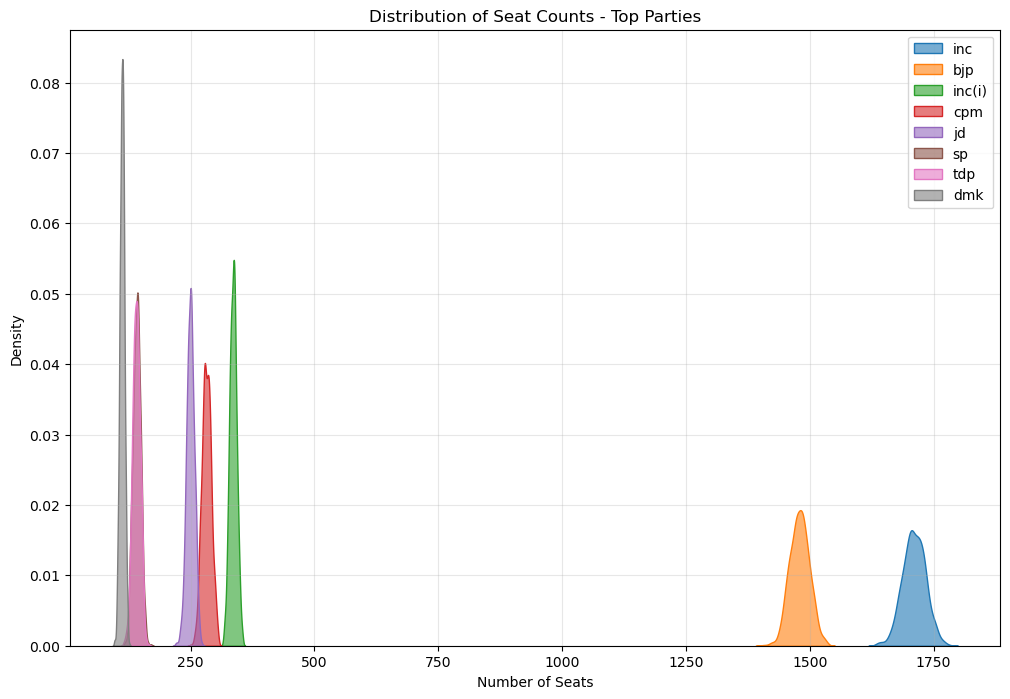

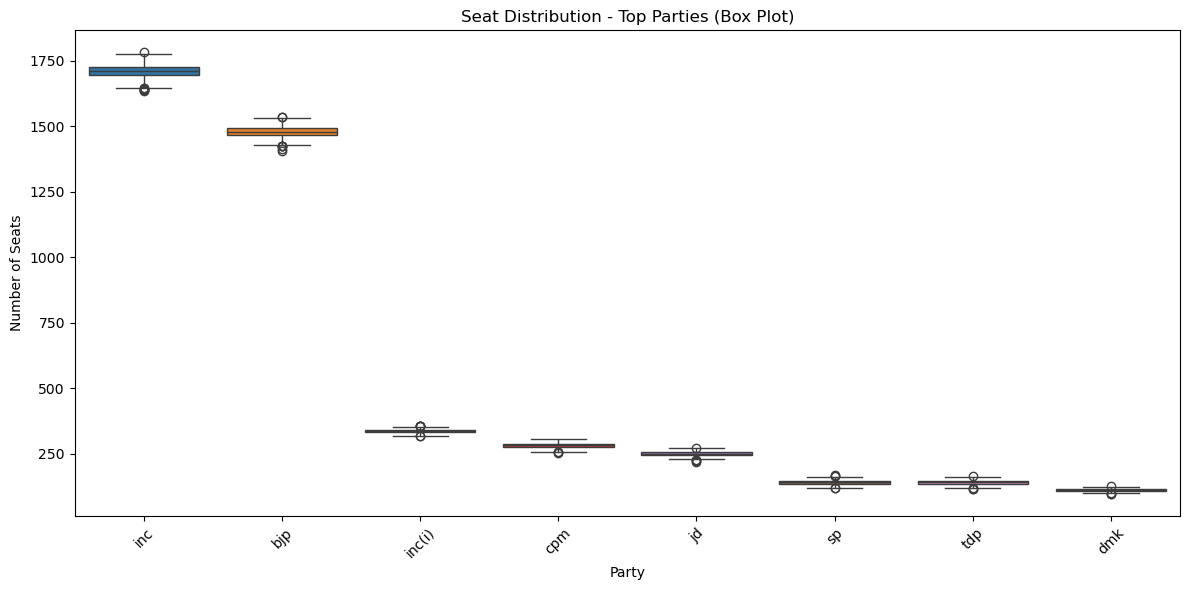

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution for top parties
top_parties = summary_stats.head(8)['Party'].tolist()

plt.figure(figsize=(12, 8))
for party in top_parties:
    if party in seat_counts.columns:
        sns.kdeplot(seat_counts[party], label=party, fill=True, alpha=0.6)

plt.xlabel('Number of Seats')
plt.ylabel('Density')
plt.title('Distribution of Seat Counts - Top Parties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Box plot for top parties
top_seat_data = seat_counts[top_parties]
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_seat_data)
plt.xticks(rotation=45)
plt.title('Seat Distribution - Top Parties (Box Plot)')
plt.ylabel('Number of Seats')
plt.tight_layout()
plt.show()

In [8]:
# Define major alliances (you may need to adjust these based on your data)
alliance_mapping = {
    'inc': 'UPA', 'inc(i)': 'UPA', 'dmk': 'UPA', 'rjd': 'UPA', 'ncp': 'UPA',
    'bjp': 'NDA', 'shs': 'NDA', 'jd(u)': 'NDA', 'admk': 'NDA',
    'cpm': 'Left', 'cpi': 'Left',
    # Add other parties as needed
}

# Map parties to alliances - CORRECTED COLUMN NAME
winners_df['Alliance'] = winners_df['Party'].map(alliance_mapping)
winners_df['Alliance'] = winners_df['Alliance'].fillna('Other')

# Calculate alliance seat counts
alliance_counts = winners_df.groupby(['Simulation', 'Alliance']).size().unstack(fill_value=0)

# Alliance summary
alliance_summary = alliance_counts.agg(['mean', 'std', lambda x: x.quantile(0.025), 
                                      lambda x: x.quantile(0.5), lambda x: x.quantile(0.975)]).T
alliance_summary.columns = ['Mean_Seats', 'Std_Dev', 'P2.5', 'Median', 'P97.5']
alliance_summary = alliance_summary.sort_values('Mean_Seats', ascending=False)

print("--- Alliance Performance ---")
display(alliance_summary)

--- Alliance Performance ---


,Mean_Seats,Std_Dev,P2.5,Median,P97.5
Alliance,,,,,
UPA,2263.054,25.524392,2215.0,2262.0,2313.000
NDA,1708.915,21.344117,1668.0,1709.0,1750.050
Other,1552.959,19.796495,1516.0,1554.0,1591.025
Left,367.072,10.479343,347.0,367.0,388.000


In [9]:
import os
import pickle
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Prepare the model components to save
model_data = {
    'seat_counts': seat_counts,
    'summary_stats': summary_stats,
    'winners_df': winners_df,
    'alliance_counts': alliance_counts,
    'alliance_summary': alliance_summary,
    'constituency_votes': constituency_votes,
    'model_parameters': {
        'NUM_SIMULATIONS': NUM_SIMULATIONS,
        'CONCENTRATION_PARAM': CONCENTRATION_PARAM,
        'simulation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_constituencies': len(constituency_votes),
        'alliance_mapping': alliance_mapping
    }
}

# Save the model
model_path = os.path.join(models_dir, 'election_simulation_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✅ Simulation model saved to: {model_path}")
print(f"📊 Model contains:")
print(f"   - Seat counts for {seat_counts.shape[0]} simulations")
print(f"   - {seat_counts.shape[1]} political parties")
print(f"   - {model_data['model_parameters']['total_constituencies']} constituencies")
print(f"   - Alliance analysis for {alliance_counts.shape[1]} alliances")

✅ Simulation model saved to: ../models\election_simulation_model.pkl
📊 Model contains:
   - Seat counts for 1000 simulations
   - 203 political parties
   - 5892 constituencies
   - Alliance analysis for 4 alliances


In [10]:
# Verify the model was saved correctly
try:
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    
    print("✅ Model verified - can be loaded successfully")
    print(f"📅 Simulation date: {loaded_model['model_parameters']['simulation_date']}")
    print(f"🔢 Number of simulations: {loaded_model['model_parameters']['NUM_SIMULATIONS']}")
    print(f"🏛️  Total parties: {loaded_model['seat_counts'].shape[1]}")
    print(f"🤝 Total alliances: {loaded_model['alliance_counts'].shape[1]}")
    
    # Show top parties from loaded model
    top_parties = loaded_model['seat_counts'].mean().sort_values(ascending=False).head(5)
    print("\n🏆 Top 5 parties by average seats:")
    for party, seats in top_parties.items():
        print(f"   - {party}: {seats:.1f} seats")
    
    # Show alliance performance
    print("\n🤝 Alliance performance:")
    for alliance, row in loaded_model['alliance_summary'].iterrows():
        print(f"   - {alliance}: {row['Mean_Seats']:.1f} seats")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")

✅ Model verified - can be loaded successfully
📅 Simulation date: 2025-11-03 11:44:41
🔢 Number of simulations: 1000
🏛️  Total parties: 203
🤝 Total alliances: 4

🏆 Top 5 parties by average seats:
   - inc: 1710.4 seats
   - bjp: 1479.2 seats
   - inc(i): 335.8 seats
   - cpm: 282.0 seats
   - jd: 249.5 seats

🤝 Alliance performance:
   - UPA: 2263.1 seats
   - NDA: 1708.9 seats
   - Other: 1553.0 seats
   - Left: 367.1 seats


In [11]:
# Add this cell after the seat_counts calculation in the notebook

# --- Alliance Calculations ---
print("Calculating alliance performance...")

# Create alliance mapping (you might need to adjust this based on your actual alliance data)
alliance_mapping = {
    'NDA': ['bjp', 'jd(u)', 'shs', 'admk', 'tdp', 'ss', 'rlp', 'pmk', 'ainrc', 'ajsup', 'bd', 'mj', 'kk', 'jn', 'km', 'kmp', 'mg', 'mpp', 'ndpp', 'npf', 'pda', 'pjp', 'rld', 'rsp', 'sdf', 'sks', 'u', 'upbd', 'wd', 'ysrcp'],
    'UPA': ['inc', 'dmk', 'nc', 'rjd', 'iuml', 'jmm', 'kcm', 'rld', 'jkpnc', 'kec(m)', 'md', 'mp', 'msr', 'myt', 'nd', 'pd', 'pmk', 'rsp', 'sdf', 'tbsp', 'tvm', 'ydp'],
    'Left': ['cpm', 'cpi', 'rsp', 'forward bloc'],
    'Other': []  # All other parties
}

# Calculate alliance seat counts
alliance_counts_list = []

for sim_num in range(NUM_SIMULATIONS):
    sim_winners = winners_df[winners_df['Simulation'] == sim_num]
    alliance_seats = {}
    
    for alliance, parties in alliance_mapping.items():
        # Count seats for parties in this alliance
        alliance_seats[alliance] = sim_winners[sim_winners['Party'].isin(parties)].shape[0]
    
    alliance_seats['Simulation'] = sim_num
    alliance_counts_list.append(alliance_seats)

alliance_counts = pd.DataFrame(alliance_counts_list)

print(f"✓ Alliance counts calculated for {len(alliance_counts)} simulations")

# --- Constituency-level probabilities ---
print("Calculating constituency-level probabilities...")

# Calculate win probabilities for each constituency
constituency_probs = winners_df.groupby(['State_Name', 'Constituency_No', 'Party']).size().reset_index(name='Wins')
constituency_probs['Win_Probability'] = constituency_probs['Wins'] / NUM_SIMULATIONS

# Find top parties in each constituency
constituency_top_parties = constituency_probs.sort_values(['State_Name', 'Constituency_No', 'Win_Probability'], ascending=[True, True, False])
constituency_summary = constituency_top_parties.groupby(['State_Name', 'Constituency_No']).head(3).reset_index(drop=True)

# Categorize seats
def categorize_seat(prob):
    if prob > 0.75:
        return 'Safe'
    elif prob > 0.60:
        return 'Likely'
    else:
        return 'Marginal'

constituency_summary['Category'] = constituency_summary['Win_Probability'].apply(categorize_seat)

print(f"✓ Constituency probabilities calculated for {len(constituency_summary)} constituency-party combinations")

# --- Save additional data ---
print("Saving enhanced simulation data...")

# Save alliance counts
alliance_counts.to_pickle('../models/alliance_counts.pkl')

# Save constituency probabilities
constituency_summary.to_pickle('../models/constituency_probabilities.pkl')

# Save the full winners dataframe for coalition analysis
winners_df.to_pickle('../models/winners_df.pkl')

print("✓ Enhanced data saved successfully")

Calculating alliance performance...
✓ Alliance counts calculated for 1000 simulations
Calculating constituency-level probabilities...
✓ Constituency probabilities calculated for 1755 constituency-party combinations
Saving enhanced simulation data...
✓ Enhanced data saved successfully
